# Fake Tweets With Bag-of-Word

In [17]:
# importing the libaries

import pandas as pd
import numpy as np
import os

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

from plotly import tools
import plotly.offline as py
import plotly.figure_factory as ff
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

from nltk.corpus import stopwords
from nltk.util import ngrams

from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split , GridSearchCV , cross_val_score , KFold
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import classification_report , confusion_matrix , f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix , roc_curve , accuracy_score , precision_score , recall_score

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB , GaussianNB
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier

from collections import defaultdict
from collections import Counter
plt.style.use('ggplot')
stop=set(stopwords.words('english'))

import re
from nltk.tokenize import word_tokenize
import gensim
import string

from tqdm import tqdm
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D
from keras.initializers import Constant
from keras.optimizers import Adam

import folium 
from folium import plugins

from spellchecker import SpellChecker

In [2]:
# Load the train and test dataset

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('submission.csv')

In [3]:
train.shape

(7613, 5)

In [4]:
train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [5]:
train.head(10)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


In [6]:
new_train = train
new_train['keyword'].fillna("No keyword",inplace=True)
new_train.isnull().sum()

id             0
keyword        0
location    2533
text           0
target         0
dtype: int64

In [7]:
# drop the location column both from train and test part

# train.drop(['location'] , axis = 1 , inplace = True)
# test.drop(['location'] , axis = 1 , inplace = True)

In [8]:
train.shape

(7613, 5)

## EDA

Text(0, 0.5, 'Number of samples')

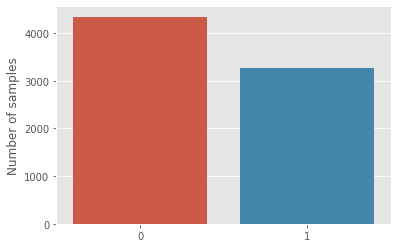

In [9]:
x=train.target.value_counts()
sns.barplot(x.index,x)
plt.gca().set_ylabel('Number of samples')

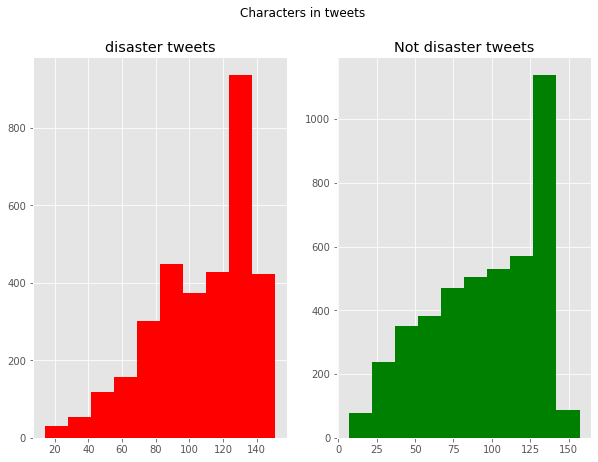

In [10]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,7))
tweet_len=train[train['target']==1]['text'].str.len()
ax1.hist(tweet_len,color='red')
ax1.set_title('disaster tweets')
tweet_len=train[train['target']==0]['text'].str.len()
ax2.hist(tweet_len,color='green')
ax2.set_title('Not disaster tweets')
fig.suptitle('Characters in tweets')
plt.show()

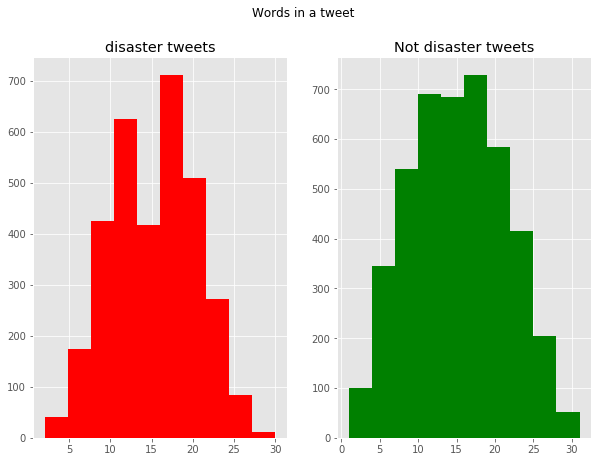

In [11]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,7))
tweet_len=train[train['target']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(tweet_len,color='red')
ax1.set_title('disaster tweets')
tweet_len=train[train['target']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(tweet_len,color='green')
ax2.set_title('Not disaster tweets')
fig.suptitle('Words in a tweet')
plt.show()

Text(0.5, 0.98, 'Average word length in each tweet')

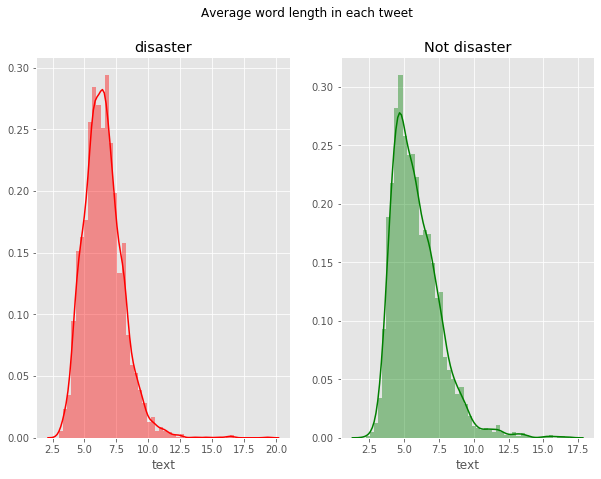

In [12]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,7))
word=train[train['target']==1]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
ax1.set_title('disaster')
word=train[train['target']==0]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='green')
ax2.set_title('Not disaster')
fig.suptitle('Average word length in each tweet')

In [13]:
# Tweets per location

cnt_ = train['location'].value_counts()
cnt_.reset_index()
cnt_ = cnt_[:20,]
trace1 = go.Bar(
                x = cnt_.index,
                y = cnt_.values,
                name = "Number of tweets in dataset according to location",
                marker = dict(color = 'rgba(200, 74, 55, 0.5)',
                             line=dict(color='rgb(0,0,0)',width=1.5)),
                )

data = [trace1]
layout = go.Layout(barmode = "group",title = 'Number of tweets depending on location')
fig = go.Figure(data = data, layout = layout)
py.iplot(fig)

In [14]:
#Number of tweets depending on location per class

train1_df = train[train["target"]==1]
train0_df = train[train["target"]==0]
cnt_1 = train1_df['location'].value_counts()
cnt_1.reset_index()
cnt_1 = cnt_1[:20,]

cnt_0 = train0_df['location'].value_counts()
cnt_0.reset_index()
cnt_0 = cnt_0[:20,]

trace1 = go.Bar(
                x = cnt_1.index,
                y = cnt_1.values,
                name = "Number of real disaster tweets",
                marker = dict(color = 'rgba(255, 74, 55, 0.5)',
                             line=dict(color='rgb(0,0,0)',width=1.5)),
                )
trace0 = go.Bar(
                x = cnt_0.index,
                y = cnt_0.values,
                name = "Number of unreal disaster tweets",
                marker = dict(color = 'rgba(79, 82, 97, 0.5)',
                             line=dict(color='rgb(0,0,0)',width=1.5)),
                )


data = [trace0,trace1]
layout = go.Layout(barmode = 'stack',title = 'Number of tweets depending on location per class')
fig = go.Figure(data = data, layout = layout)
py.iplot(fig)

#### Visualize per location using map

In [15]:
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter


df = train['location'].value_counts()[:20,]
df = pd.DataFrame(df)
df = df.reset_index()
df.columns = ['location', 'counts'] 
geolocator = Nominatim(user_agent="specify_your_app_name_here")
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)
dictt_latitude = {}
dictt_longitude = {}
for i in df['location'].values:
    print(i)
    location = geocode(i)
    dictt_latitude[i] = location.latitude
    dictt_longitude[i] = location.longitude
    
df['latitude']= df['location'].map(dictt_latitude)
df['longitude'] = df['location'].map(dictt_longitude)

USA
New York
United States
London
Canada
Nigeria
UK
Los Angeles, CA
India
Mumbai
Washington, DC
Kenya
Worldwide
Australia
Chicago, IL
California
New York, NY
California, USA
Everywhere
San Francisco


In [18]:
map1 = folium.Map(location=[10.0, 10.0], tiles='CartoDB dark_matter', zoom_start=2.3)
markers = []
for i, row in df.iterrows():
    loss = row['counts']
    if row['counts'] > 0:
        count = row['counts']*0.4
    folium.CircleMarker([float(row['latitude']), float(row['longitude'])], radius=float(count), color='#ef4f61', fill=True).add_to(map1)
map1

It is clear that most of the tweets from america region.

#### Common Stopwords in tweets

In [19]:
def create_corpus(target):
    corpus =[]
    
    for x in train[train['target'] == target]['text'].str.split():
        for i in x:
            corpus.append(i)
            
    return corpus

In [20]:
corpus = create_corpus(1)

In [21]:
dic = defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1
        
top = sorted(dic.items(), key = lambda x:x[1] , reverse = True)[:10] 

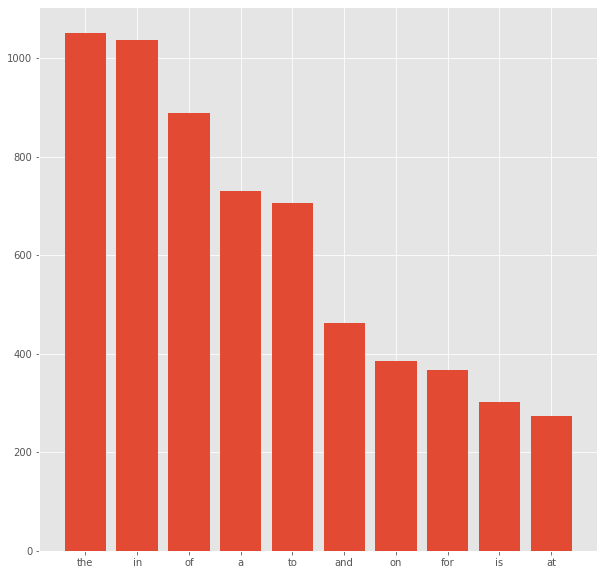

In [22]:
x , y = zip(*top)
plt.figure(figsize = (10 , 10))
plt.bar(x , y);

#### Analyzing Punctuations

<BarContainer object of 18 artists>

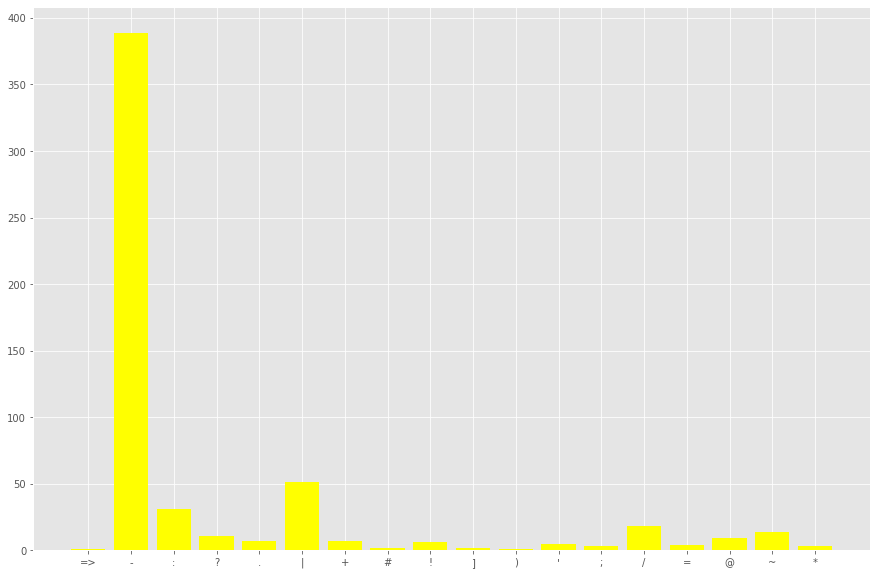

In [23]:
plt.figure(figsize=(15 , 10))

corpus = create_corpus(1)

dic=defaultdict(int)
import string
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1
        
x,y=zip(*dic.items())
plt.bar(x,y , color = 'yellow')

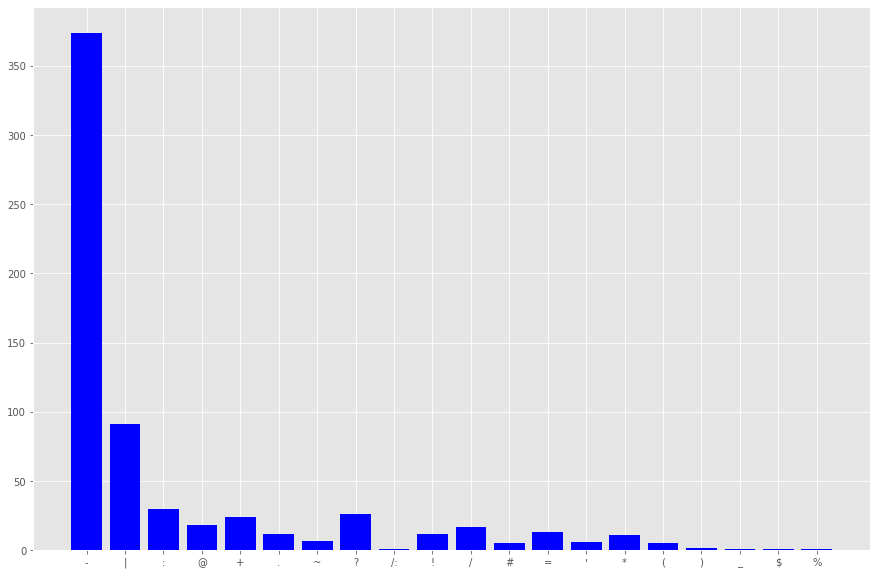

In [24]:
plt.figure(figsize=(15 , 10))
corpus = create_corpus(0)

dic=defaultdict(int)
import string
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1
        
x,y=zip(*dic.items())
plt.bar(x , y , color = 'blue');

#### Common Words

In [25]:
counter=Counter(corpus)
most=counter.most_common()

x=[]
y=[]

for word,count in most[:40]:
    if (word not in stop) :
        x.append(word)
        y.append(count)

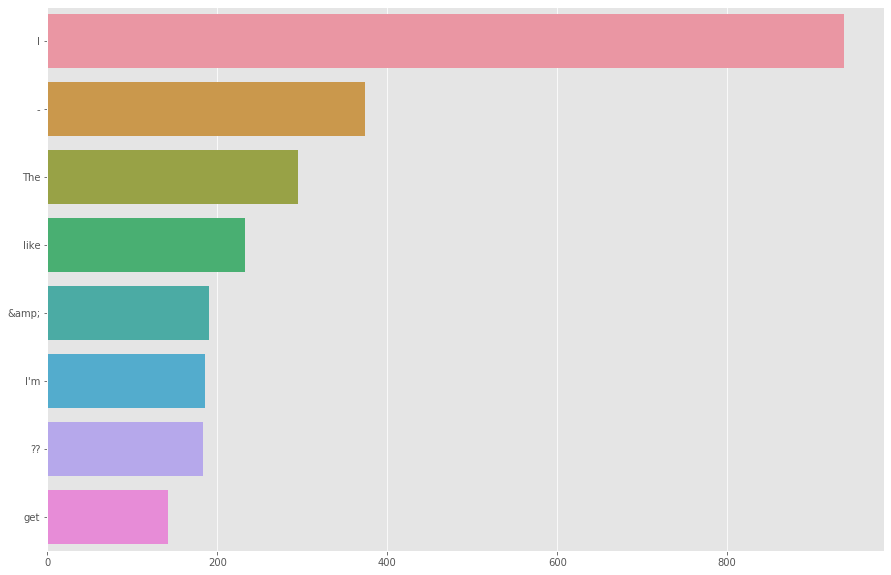

In [26]:
plt.figure(figsize=(15 , 10))
sns.barplot(x = y , y = x);

In [27]:
df = pd.concat([train , test])

C:\Users\Mahmudur Limon\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




## Data Preprocessing

1 . Removing stop words(Optional)

2 . Remove Punctuations

3 . Remove Html

4 . Remove Emojis

5 . Spelling Corrections

6 . Removing Urls

In [28]:
## Concate both train and test part
df_new = pd.concat([train , test])

C:\Users\Mahmudur Limon\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




In [29]:
df_new.shape

(10876, 5)

In [30]:
df_new.isnull().sum()

id             0
keyword       26
location    3638
target      3263
text           0
dtype: int64

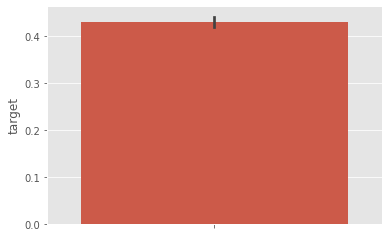

In [31]:
sns.barplot(y = 'target' , data = df_new)

In [32]:
df_new.head(20)

,id,keyword,location,target,text
0,1,No keyword,NaN,1.0,Our Deeds are the Reason of this #earthquake M...
1,4,No keyword,NaN,1.0,Forest fire near La Ronge Sask. Canada
2,5,No keyword,NaN,1.0,All residents asked to 'shelter in place' are ...
3,6,No keyword,NaN,1.0,"13,000 people receive #wildfires evacuation or..."
4,7,No keyword,NaN,1.0,Just got sent this photo from Ruby #Alaska as ...
5,8,No keyword,NaN,1.0,#RockyFire Update => California Hwy. 20 closed...
6,10,No keyword,NaN,1.0,#flood #disaster Heavy rain causes flash flood...
7,13,No keyword,NaN,1.0,I'm on top of the hill and I can see a fire in...
8,14,No keyword,NaN,1.0,There's an emergency evacuation happening now ...
9,15,No keyword,NaN,1.0,I'm afraid that the tornado is coming to our a...


In [33]:
df_new.tail()

,id,keyword,location,target,text
3258,10861,NaN,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,NaN,NaN,NaN,Storm in RI worse than last hurricane. My city...
3260,10868,NaN,NaN,NaN,Green Line derailment in Chicago http://t.co/U...
3261,10874,NaN,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...
3262,10875,NaN,NaN,NaN,#CityofCalgary has activated its Municipal Eme...


In [34]:
df_new['text'][0]

0    Our Deeds are the Reason of this #earthquake M...
0                   Just happened a terrible car crash
Name: text, dtype: object

In [35]:
df_new['text'][12]

12    #raining #flooding #Florida #TampaBay #Tampa 1...
12                               No don't tell me that!
Name: text, dtype: object

In [36]:
train['text'][0]

'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'

### Removing URLS

In [37]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

In [38]:
train['text'] = train['text'].apply(lambda x : remove_URL(x))
df_new['text'] = df_new['text'].apply(lambda x : remove_URL(x))

### Remove HTML tags

In [39]:
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

In [40]:
train['text'] = train['text'].apply(lambda x : remove_html(x))
df_new['text'] = df_new['text'].apply(lambda x : remove_URL(x))

### Remove Emoji's

In [41]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [42]:
df_new['text']=df_new['text'].apply(lambda x: remove_emoji(x))
train['text'] = train['text'].apply(lambda x : remove_emoji(x))

In [43]:
df_new['text'][12]

12    #raining #flooding #Florida #TampaBay #Tampa 1...
12                               No don't tell me that!
Name: text, dtype: object

### Remove Punctuations

In [44]:
def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

In [45]:
df_new['text'] = df_new['text'].apply(lambda x : remove_punct(x))
train['text'] = train['text'].apply(lambda x : remove_punct(x))

In [46]:
df_new['text'][12]

12    raining flooding Florida TampaBay Tampa 18 or ...
12                                 No dont tell me that
Name: text, dtype: object

In [47]:
train['text'][12]

'raining flooding Florida TampaBay Tampa 18 or 19 days Ive lost count '

In [48]:
train.head()

,id,keyword,location,text,target
0,1,No keyword,NaN,Our Deeds are the Reason of this earthquake Ma...,1
1,4,No keyword,NaN,Forest fire near La Ronge Sask Canada,1
2,5,No keyword,NaN,All residents asked to shelter in place are be...,1
3,6,No keyword,NaN,13000 people receive wildfires evacuation orde...,1
4,7,No keyword,NaN,Just got sent this photo from Ruby Alaska as s...,1


In [49]:
train.tail()

,id,keyword,location,text,target
7608,10869,No keyword,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,No keyword,NaN,ariaahrary TheTawniest The out of control wild...,1
7610,10871,No keyword,NaN,M194 0104 UTC5km S of Volcano Hawaii,1
7611,10872,No keyword,NaN,Police investigating after an ebike collided w...,1
7612,10873,No keyword,NaN,The Latest More Homes Razed by Northern Califo...,1


### Spelling corrections

In [50]:
spell = SpellChecker()
def correct_spellings(text):
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)

In [51]:
# df_new['text'] = df_new['text'].apply(lambda x : correct_spellings(x))
# train['text'] = train['text'].apply(lambda x : correct_spellings(x))

In [52]:
train.tail()

,id,keyword,location,text,target
7608,10869,No keyword,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,No keyword,NaN,ariaahrary TheTawniest The out of control wild...,1
7610,10871,No keyword,NaN,M194 0104 UTC5km S of Volcano Hawaii,1
7611,10872,No keyword,NaN,Police investigating after an ebike collided w...,1
7612,10873,No keyword,NaN,The Latest More Homes Razed by Northern Califo...,1


In [53]:
df_new.head()

,id,keyword,location,target,text
0,1,No keyword,NaN,1.0,Our Deeds are the Reason of this earthquake Ma...
1,4,No keyword,NaN,1.0,Forest fire near La Ronge Sask Canada
2,5,No keyword,NaN,1.0,All residents asked to shelter in place are be...
3,6,No keyword,NaN,1.0,13000 people receive wildfires evacuation orde...
4,7,No keyword,NaN,1.0,Just got sent this photo from Ruby Alaska as s...


## Convert Text to BOW

In [54]:
x = train.drop(['keyword' , 'location' , 'target'] , axis = 1)
y = train['target']

In [55]:
x

,id,text
0,1,Our Deeds are the Reason of this earthquake Ma...
1,4,Forest fire near La Ronge Sask Canada
2,5,All residents asked to shelter in place are be...
3,6,13000 people receive wildfires evacuation orde...
4,7,Just got sent this photo from Ruby Alaska as s...
...,...,...
7608,10869,Two giant cranes holding a bridge collapse int...
7609,10870,ariaahrary TheTawniest The out of control wild...
7610,10871,M194 0104 UTC5km S of Volcano Hawaii
7611,10872,Police investigating after an ebike collided w...


In [56]:
test

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...


In [57]:
final_test = test.drop(['keyword' , 'location'] , axis = 1)
final_test

,id,text
0,0,Just happened a terrible car crash
1,2,"Heard about #earthquake is different cities, s..."
2,3,"there is a forest fire at spot pond, geese are..."
3,9,Apocalypse lighting. #Spokane #wildfires
4,11,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...
3258,10861,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,Storm in RI worse than last hurricane. My city...
3260,10868,Green Line derailment in Chicago http://t.co/U...
3261,10874,MEG issues Hazardous Weather Outlook (HWO) htt...


In [58]:
final_test.shape

(3263, 2)

In [59]:
x_train , x_test , y_train , y_test = train_test_split(x , y , test_size = 0.20 , random_state = 78)

In [60]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)

(6090, 2)
(1523, 2)
(6090,)


### BOW on Text


In [61]:
count_vect = CountVectorizer()
X_train_BOW = count_vect.fit_transform(x_train['text'])
X_test_BOW = count_vect.transform(x_test['text'])
test_BOW = count_vect.transform(test['text'])

In [62]:
print("**Bow Vectorizer**")
print("="*50)


print(X_train_BOW.shape)
print(X_test_BOW.shape)
print(test_BOW.shape)

**Bow Vectorizer**
(6090, 15510)
(1523, 15510)
(3263, 15510)


In [63]:
X_train_BOW

<6090x15510 sparse matrix of type '<class 'numpy.int64'>'
	with 78145 stored elements in Compressed Sparse Row format>

In [64]:
test_BOW

<3263x15510 sparse matrix of type '<class 'numpy.int64'>'
	with 40373 stored elements in Compressed Sparse Row format>

## Apply DIfferent ML model on BOW

## Logistic Regression on BOW

In [65]:
#Standardising the train and test data

sc = StandardScaler(copy = True , with_mean = False , with_std = True)
X_train = sc.fit_transform(X_train_BOW)
X_test = sc.transform(X_test_BOW)
Test = sc.transform(test_BOW)

In [66]:
tuned_parameters = [10**-4, 10**-2, 10**0, 10**2, 10**4]

cv_scores = []

for i in tqdm(tuned_parameters):
    model = LogisticRegression(penalty = 'l1' , C = i , n_jobs = -1)
    scores = cross_val_score(model , X_train , y_train , cv = 10 , scoring = 'accuracy' , n_jobs = -1)
    cv_scores.append(scores.mean())

100%|██████████| 5/5 [00:06<00:00,  1.23s/it]


In [67]:
optimal_C = tuned_parameters[cv_scores.index(max(cv_scores))]
print('\nThe optimal value of C is %.3f.' % optimal_C)


The optimal value of C is 1.000.


In [70]:
lr = LogisticRegression(penalty = 'l2' , C = 0.0001 , n_jobs = -1)
lr.fit(X_train , y_train)
pred = lr.predict(X_test)

ac = accuracy_score(y_test , pred)
print(ac*100)

80.03939592908733


***Test Data Report***
Best C =  1
AUC =  77.96955662987365


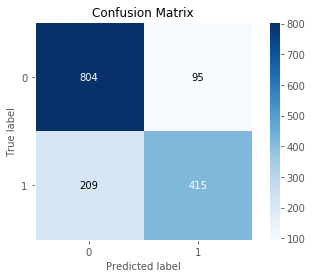

In [71]:
from sklearn import metrics
import scikitplot as skplt

print("***Test Data Report***")
print("Best C = ",optimal_C)
fpr, tpr, threshold = roc_curve(y_test , lr.predict(X_test))
auc = metrics.auc(fpr, tpr)
print("AUC = ",auc*100)
skplt.metrics.plot_confusion_matrix(y_test, pred)
plt.show()

In [72]:
fpr, tpr, threshold = metrics.roc_curve(y_test , lr.predict(X_test))
fpr2, tpr2, threshold2 = metrics.roc_curve(y_test , lr.predict(X_test))

roc_auc = metrics.auc(fpr, tpr)
roc_auc2 = metrics.auc(fpr2, tpr2)

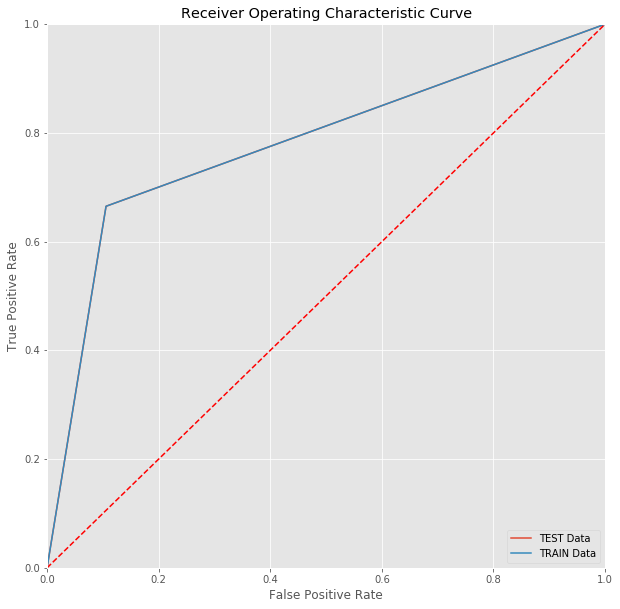

In [73]:
# plot ROC-curve
plt.figure(figsize = (10 , 10))
plt.title('Receiver Operating Characteristic Curve')
plt.gca()
plt.plot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc)
plt.plot(fpr2, tpr2, label = 'AUC = %0.2f' % roc_auc2)
plt.legend(['TEST Data', 'TRAIN Data'],loc = 'lower right')

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [74]:
feature_name = count_vect.get_feature_names()
w = lr.coef_
weight=w.reshape(-1)
sorted_feature = np.argsort(weight)
top_20_positive_feature=sorted_feature[:-20:-1]

In [75]:
print("Positive feature top 20 :")
print("-------")
for i in top_20_positive_feature:
    print("%s\t-->\t%f"%(feature_name[i],weight[i]))

Positive feature top 20 :
-------
california	-->	0.019640
hiroshima	-->	0.019570
in	-->	0.018866
wildfire	-->	0.016985
suicide	-->	0.016875
fires	-->	0.016419
killed	-->	0.016347
mh370	-->	0.015491
bombing	-->	0.015156
fire	-->	0.014749
northern	-->	0.013964
homes	-->	0.013523
atomic	-->	0.013430
bomber	-->	0.012830
debris	-->	0.012625
confirmed	-->	0.012550
train	-->	0.012366
pm	-->	0.012305
outbreak	-->	0.011907


In [76]:
w = lr.coef_
weight=w.reshape(-1)
sorted_feature = np.argsort(weight)
feature_name = count_vect.get_feature_names()
top_20_negative_feature = sorted_feature[:20]

In [77]:
print("Negative feature top 20 :")
print("-------")
for i in top_20_negative_feature:
    print("%s\t -->\t%f  "%(feature_name[i],weight[i]))

Negative feature top 20 :
-------
you	 -->	-0.026926  
my	 -->	-0.023856  
im	 -->	-0.017984  
just	 -->	-0.015398  
me	 -->	-0.015286  
body	 -->	-0.014430  
and	 -->	-0.013484  
love	 -->	-0.013063  
your	 -->	-0.012762  
like	 -->	-0.012751  
full	 -->	-0.011806  
so	 -->	-0.011805  
new	 -->	-0.011458  
is	 -->	-0.011384  
panic	 -->	-0.011210  
bags	 -->	-0.011051  
youtube	 -->	-0.011016  
or	 -->	-0.010993  
it	 -->	-0.010852  
wrecked	 -->	-0.010693  


In the above list it is clear that there are so many stop words that affects our model.we have to remove the stopwords.

## Apply KNN on BOW

In [78]:
knn = KNeighborsClassifier()
knn.fit(X_train , y_train)

y_pred_knn = knn.predict(X_test)

ac = accuracy_score(y_test , y_pred_knn)
print(ac*100)

67.76099803020355


In [79]:
n_folds = 5
parameters = {
        'n_neighbors': range (2 , 50 , 2)
        }


In [80]:
knn = KNeighborsClassifier()

tree = GridSearchCV(estimator = knn , param_grid = parameters , cv = n_folds , n_jobs = -1 , return_train_score = True)
tree.fit(X_train , y_train)

score1 = tree.cv_results_

print(pd.DataFrame(score1).head())
print(tree.best_params_)

   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.005007      0.001582         0.451175        0.037390   
1       0.005157      0.005072         0.503520        0.012195   
2       0.003417      0.003795         0.432550        0.026523   
3       0.007649      0.003904         0.422248        0.025234   
4       0.002013      0.004027         0.406059        0.015089   

  param_n_neighbors               params  split0_test_score  \
0                 2   {'n_neighbors': 2}           0.666120   
1                 4   {'n_neighbors': 4}           0.639048   
2                 6   {'n_neighbors': 6}           0.639869   
3                 8   {'n_neighbors': 8}           0.621001   
4                10  {'n_neighbors': 10}           0.612797   

   split1_test_score  split2_test_score  split3_test_score  ...  \
0           0.645611           0.638752           0.655711  ...   
1           0.645611           0.615764           0.645029  ...   
2           0.636

In [81]:
score1 = pd.DataFrame(score1)
score1.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.005007,0.001582,0.451175,0.037390,2,{'n_neighbors': 2},0.666120,0.645611,0.638752,0.655711,...,0.649918,0.009820,1,0.717101,0.728187,0.727011,0.722348,0.718859,0.722701,0.004357
1,0.005157,0.005072,0.503520,0.012195,4,{'n_neighbors': 4},0.639048,0.645611,0.615764,0.645029,...,0.633662,0.012152,2,0.649764,0.712790,0.659278,0.655859,0.657501,0.667038,0.023099
2,0.003417,0.003795,0.432550,0.026523,6,{'n_neighbors': 6},0.639869,0.636587,0.615764,0.642564,...,0.629557,0.012567,3,0.646890,0.661466,0.654351,0.651344,0.631849,0.649180,0.009879
3,0.007649,0.003904,0.422248,0.025234,8,{'n_neighbors': 8},0.621001,0.635767,0.609195,0.626130,...,0.620361,0.010095,4,0.628413,0.660029,0.635468,0.628155,0.623846,0.635182,0.012970
4,0.002013,0.004027,0.406059,0.015089,10,{'n_neighbors': 10},0.612797,0.622642,0.605911,0.617091,...,0.613300,0.006067,5,0.616301,0.634777,0.624179,0.623435,0.620562,0.623851,0.006124


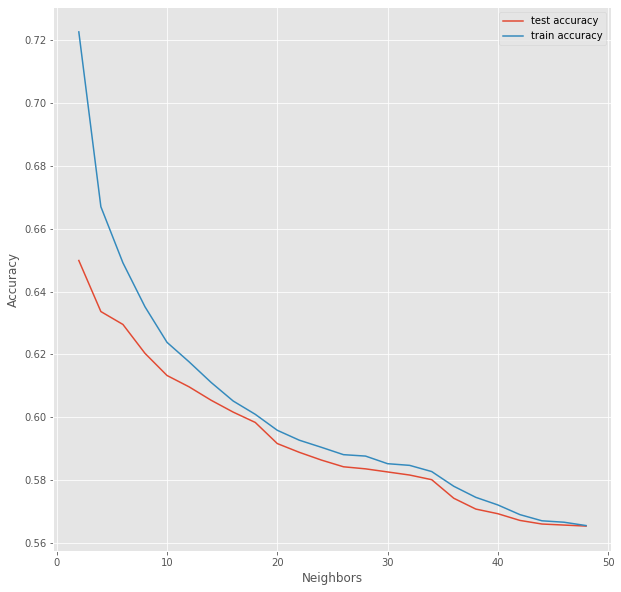

In [84]:
plt.figure(figsize=(10 , 10))
plt.plot(score1['param_n_neighbors'], score1['mean_test_score'])
plt.plot(score1['param_n_neighbors'], score1['mean_train_score'])
plt.xlabel('Neighbors')
plt.ylabel('Accuracy')
plt.legend(['test accuracy', 'train accuracy'] , loc='upper right')
#plt.xscale('log')

In [87]:
knn = KNeighborsClassifier(n_neighbors = 8 , algorithm = 'kd_tree')
knn.fit(X_train , y_train)

y_pred_knn = knn.predict(X_test)

ac_knn = accuracy_score(y_test , y_pred_knn)
print('After Cross-validation: ',ac*100)

C:\Users\Mahmudur Limon\Anaconda3\lib\site-packages\sklearn\neighbors\base.py:216: UserWarning:

cannot use tree with sparse input: using brute force



After Cross-validation:  67.76099803020355


## Naive-Bayes on BOW

In [88]:
alpha = [] 
i = 0.001

while(i <= 1000):
    alpha.append(np.round(i,3))
    i *= 3

cv_scores = []

for k in tqdm(alpha):
    model = MultinomialNB(alpha = k)
    scores = cross_val_score(model , X_train , y_train , cv = 10 , scoring = 'f1_macro' , n_jobs = -1)
    cv_scores.append(scores.mean()) 

100%|██████████| 13/13 [00:01<00:00, 11.29it/s]


In [89]:
optimal_alpha = alpha[cv_scores.index(max(cv_scores))]
print('\nThe optimal value of alpha is %.3f.' % optimal_alpha)


The optimal value of alpha is 531.441.


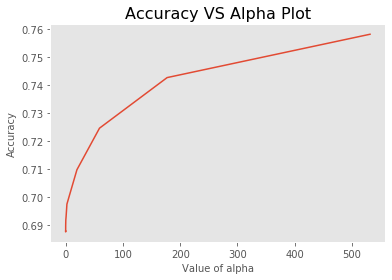


*******Train Data Report******

Alpha values :
 [0.001, 0.003, 0.009, 0.027, 0.081, 0.243, 0.729, 2.187, 6.561, 19.683, 59.049, 177.147, 531.441]

F1 Score for each value of alpha :
  [68.786 68.756 68.864 68.988 69.04  69.18  69.294 69.747 70.057 70.974
 72.455 74.26  75.805]


In [90]:
# plot accuracy vs alpha 
plt.plot(alpha, cv_scores)
plt.xlabel('Value of alpha',size=10)
plt.ylabel('Accuracy',size=10)
plt.title('Accuracy VS Alpha Plot',size=16)
plt.grid()
plt.show()
print("\n*******Train Data Report******");
print("\nAlpha values :\n",alpha)
print("\nF1 Score for each value of alpha :\n ", np.round(cv_scores,5)*100)

In [91]:
model_bow_multinomial = MultinomialNB(alpha = optimal_alpha)

model_bow_multinomial.fit(X_train , y_train)

pred = model_bow_multinomial.predict(X_test)

***Test Data Report***
Accuracy =  79.51411687458962
f1_score =  78.47256200324016
precision_score =  79.13218556563797
recall_score =  78.08836741678789


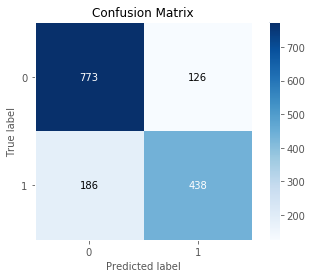

In [92]:
print("***Test Data Report***")
print('Accuracy = ', accuracy_score(y_test, pred)*100)
print("f1_score = ",f1_score(y_test, pred, average='macro')*100)

print("precision_score = " , precision_score(y_test , pred, average='macro')*100)
print("recall_score = " , recall_score(y_test, pred, average='macro')*100)
skplt.metrics.plot_confusion_matrix(y_test, pred)

plt.show()

In [93]:
print(classification_report(y_test , pred))

              precision    recall  f1-score   support

           0       0.81      0.86      0.83       899
           1       0.78      0.70      0.74       624

    accuracy                           0.80      1523
   macro avg       0.79      0.78      0.78      1523
weighted avg       0.79      0.80      0.79      1523



## SVM on BOW

In [94]:
sv = SVC()
sv.fit(X_train , y_train)

y_pred_svm = sv.predict(X_test)

ac_svr = accuracy_score(y_test , y_pred_svm)
print(ac_svr*100)

C:\Users\Mahmudur Limon\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning:

The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.



76.62508207485227


In [95]:
folds = KFold(n_splits = 5, shuffle = True, random_state = 4)
params = {"C": [0.01 , 0.1, 1, 10, 100, 1000]}

model = SVC()

model_cv_C = GridSearchCV(estimator = model, param_grid = params, cv = folds , verbose = 1 , return_train_score=True , n_jobs = -1)
model_cv_C.fit(X_train, y_train) 


cv_results = pd.DataFrame(model_cv_C.cv_results_)
cv_results

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  2.3min finished
C:\Users\Mahmudur Limon\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning:

The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.



,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,9.295491,0.273822,1.829169,0.094821,0.01,{'C': 0.01},0.581281,0.536946,0.574713,0.591133,...,0.565353,0.021570,5,0.561371,0.572455,0.563013,0.558908,0.571018,0.565353,0.005393
1,8.619675,0.051686,1.822992,0.138751,0.1,{'C': 0.1},0.581281,0.536946,0.574713,0.591133,...,0.565353,0.021570,5,0.561371,0.572455,0.563013,0.558908,0.571018,0.565353,0.005393
2,7.562573,0.543722,1.699603,0.095824,1,{'C': 1},0.728243,0.684729,0.733990,0.729064,...,0.712479,0.022082,4,0.969417,0.967980,0.969007,0.967159,0.967159,0.968144,0.000931
3,7.359743,0.080361,1.495804,0.069315,10,{'C': 10},0.744663,0.727422,0.783251,0.770936,...,0.754023,0.020195,1,0.989943,0.989943,0.989327,0.987274,0.988506,0.988998,0.001011
4,7.948629,0.559158,1.994469,0.178700,100,{'C': 100},0.738095,0.721675,0.775862,0.760263,...,0.745320,0.019905,2,0.991174,0.991174,0.991174,0.989327,0.990148,0.990599,0.000750
5,9.416902,0.560285,1.714891,0.486116,1000,{'C': 1000},0.738916,0.720033,0.772578,0.756979,...,0.744499,0.018354,3,0.991174,0.991174,0.991174,0.989327,0.990148,0.990599,0.000750


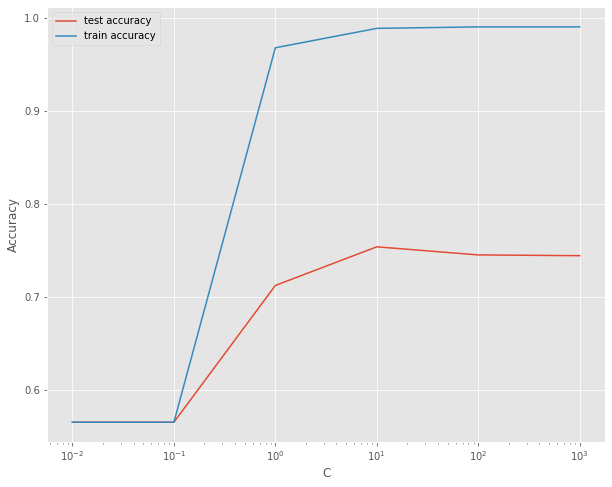

In [96]:
plt.figure(figsize=(10 , 8))
plt.plot(cv_results['param_C'], cv_results['mean_test_score'])
plt.plot(cv_results['param_C'], cv_results['mean_train_score'])
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.legend(['test accuracy', 'train accuracy'], loc='upper left')
plt.xscale('log')

In [97]:
folds = KFold(n_splits = 5, shuffle = True, random_state = 4)
gamma = {'gamma': [1, 0.1, 0.01, 0.001, 0.0001]}

model = SVC()

model_cv_g = GridSearchCV(estimator = model, param_grid = gamma, cv = folds , verbose = 1 , return_train_score=True ,  n_jobs = -1)
model_cv_g.fit(X_train, y_train) 

cv_results_g = pd.DataFrame(model_cv_g.cv_results_)
cv_results_g

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  2.2min finished


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,12.755375,0.441773,2.496817,0.086951,1,{'gamma': 1},0.628900,0.606732,0.629721,0.642036,...,0.622660,0.014131,5,0.991174,0.991174,0.991174,0.989327,0.990148,0.990599,0.000750
1,11.464798,0.399210,2.521434,0.143310,0.1,{'gamma': 0.1},0.628900,0.607553,0.631363,0.642857,...,0.623317,0.014347,4,0.991174,0.991174,0.991174,0.989327,0.990148,0.990599,0.000750
2,8.373432,0.765490,1.870413,0.137773,0.01,{'gamma': 0.01},0.628900,0.609195,0.633005,0.643678,...,0.624138,0.014413,3,0.991174,0.991174,0.991174,0.989327,0.990148,0.990599,0.000750
3,9.372776,0.593765,1.907481,0.181097,0.001,{'gamma': 0.001},0.641215,0.619048,0.660099,0.654351,...,0.638095,0.017998,2,0.989532,0.989532,0.988916,0.987069,0.988095,0.988629,0.000941
4,7.093655,0.508552,1.489737,0.246865,0.0001,{'gamma': 0.0001},0.714286,0.669951,0.717570,0.716749,...,0.699672,0.020512,1,0.977011,0.977833,0.977833,0.975985,0.977217,0.977176,0.000680


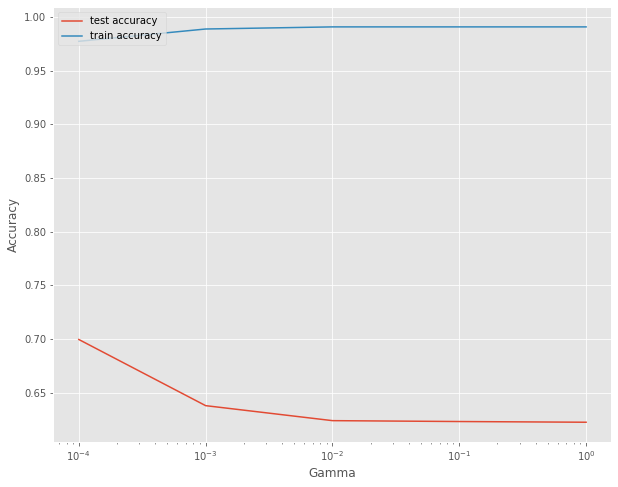

In [98]:
plt.figure(figsize=(10 , 8))
plt.plot(cv_results_g['param_gamma'], cv_results_g['mean_test_score'])
plt.plot(cv_results_g['param_gamma'], cv_results_g['mean_train_score'])
plt.xlabel('Gamma')
plt.ylabel('Accuracy')
plt.legend(['test accuracy', 'train accuracy'], loc='upper left')
plt.xscale('log')

In [99]:
print(model_cv_C.best_params_)
print(model_cv_g.best_params_)

{'C': 10}
{'gamma': 0.0001}


In [100]:
sv = SVC(C = 10 , gamma = 0.0001)
sv.fit(X_train , y_train)

y_pred_svm = sv.predict(X_test)

ac_svr = accuracy_score(y_test , y_pred_svm)
print(ac_svr*100)

76.49376231122784


In [101]:
from sklearn import linear_model
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score

alpha = [10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**3, 10**4]
auc_score=[]


for i in tqdm(alpha):
    model = linear_model.SGDClassifier(alpha=i, loss='hinge', class_weight='balanced')
    model.fit(X_train, y_train)
    
    Cal_CV_model = CalibratedClassifierCV(model, method="sigmoid",cv=10)
    Cal_CV_model.fit(X_train, y_train)
    predict_y = Cal_CV_model.predict_proba(X_train)
    preds = predict_y[:,1]
    roc_auc = roc_auc_score(y_train, preds)
    auc_score.append(roc_auc)

  0%|          | 0/9 [00:00<?, ?it/s]C:\Users\Mahmudur Limon\Anaconda3\lib\site-packages\sklearn\calibration.py:455: RuntimeWarning:

invalid value encountered in multiply

C:\Users\Mahmudur Limon\Anaconda3\lib\site-packages\sklearn\calibration.py:455: RuntimeWarning:

invalid value encountered in multiply

C:\Users\Mahmudur Limon\Anaconda3\lib\site-packages\sklearn\calibration.py:455: RuntimeWarning:

invalid value encountered in multiply

100%|██████████| 9/9 [00:03<00:00,  2.89it/s]


In [102]:
# determining best value of alpha
optimal_alpha = alpha[auc_score.index(max(auc_score))]
print('\nThe optimal value of alpha is %.3f.' % optimal_alpha)


The optimal value of alpha is 0.010.


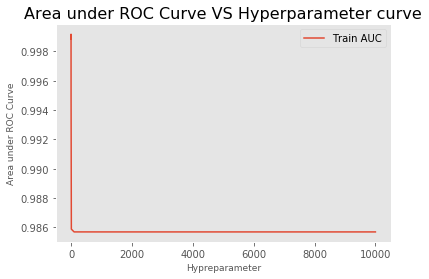

In [103]:
# plot accuracy vs alpha 
plt.plot(alpha, auc_score,label="Train AUC")
plt.xlabel('Hypreparameter',size=9)
plt.ylabel('Area under ROC Curve',size=9)
plt.title('Area under ROC Curve VS Hyperparameter curve',size=16)
plt.legend(loc='best')
plt.grid()
plt.show()

***Test Data Report***
Best alpha =  0.01
AUC =  74.6127285302758


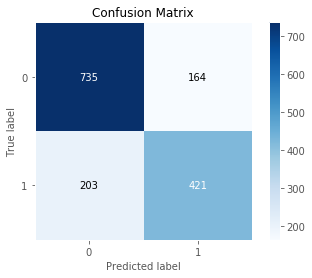

In [104]:
model = linear_model.SGDClassifier(alpha=optimal_alpha, loss='hinge', class_weight='balanced')
model.fit(X_train, y_train)

lr = CalibratedClassifierCV(model, method="sigmoid",cv=10)
lr.fit(X_train, y_train)
pred = lr.predict(X_test)


print("***Test Data Report***")
print("Best alpha = ",optimal_alpha)
fpr, tpr, threshold = metrics.roc_curve(y_test, lr.predict(X_test))
auc = metrics.auc(fpr, tpr)
print("AUC = ",auc*100)
skplt.metrics.plot_confusion_matrix(y_test, pred)
plt.show()

## Decision Tree on BOW

In [105]:
dt = DecisionTreeClassifier()
dt.fit(X_train , y_train)


y_pred_dt = dt.predict(X_test)

ac = accuracy_score(y_test , y_pred_dt)
print(ac*100)

73.99868680236375


In [106]:
n_folds = 5
parameters = {'min_samples_split': range(20 , 200 , 20)}

dtree = DecisionTreeClassifier(random_state = 100)

tree_split = GridSearchCV(dtree, parameters , cv=n_folds , n_jobs = -1 , return_train_score = True)
tree_split.fit(X_train, y_train)


cv_results_ms = pd.DataFrame(tree_split.cv_results_)
cv_results_ms

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,1.953175,0.102337,0.001995,8.844012e-07,20,{'min_samples_split': 20},0.719442,0.744873,0.731527,0.737880,...,0.731199,0.009485,7,0.939848,0.947033,0.939039,0.937615,0.947055,0.942118,0.004085
1,1.939411,0.297783,0.002196,3.978266e-04,40,{'min_samples_split': 40},0.716161,0.734208,0.734811,0.735415,...,0.731034,0.007451,9,0.916034,0.932047,0.917693,0.914016,0.923866,0.920731,0.006546
2,1.726778,0.147340,0.002195,3.990655e-04,60,{'min_samples_split': 60},0.722724,0.732568,0.728243,0.732950,...,0.731199,0.005564,7,0.904948,0.923219,0.909893,0.897189,0.914221,0.909894,0.008743
3,1.712617,0.152035,0.002195,3.989943e-04,80,{'min_samples_split': 80},0.734208,0.731747,0.732348,0.738702,...,0.736289,0.004752,1,0.898378,0.905564,0.900452,0.890417,0.899856,0.898933,0.004898
4,1.584957,0.072152,0.001996,3.504023e-07,100,{'min_samples_split': 100},0.723544,0.730927,0.730706,0.735415,...,0.733333,0.007426,5,0.891809,0.890166,0.891831,0.884260,0.887749,0.889163,0.002869
5,1.729573,0.187618,0.002195,3.991612e-04,120,{'min_samples_split': 120},0.722724,0.726825,0.732348,0.737880,...,0.733990,0.009581,3,0.888729,0.879080,0.887315,0.884055,0.885697,0.884975,0.003337
6,1.496196,0.118268,0.002594,4.886363e-04,140,{'min_samples_split': 140},0.723544,0.726825,0.729064,0.737880,...,0.733990,0.010475,3,0.880517,0.870868,0.884647,0.881592,0.882413,0.880008,0.004767
7,1.459296,0.105934,0.002394,4.876239e-04,160,{'min_samples_split': 160},0.727646,0.727646,0.729064,0.737880,...,0.734647,0.009031,2,0.878054,0.866557,0.884647,0.881592,0.878719,0.877914,0.006140
8,1.328453,0.246960,0.001996,6.312811e-04,180,{'min_samples_split': 180},0.724364,0.723544,0.729885,0.737880,...,0.733169,0.009932,6,0.875180,0.863067,0.882184,0.881592,0.876257,0.875656,0.006884


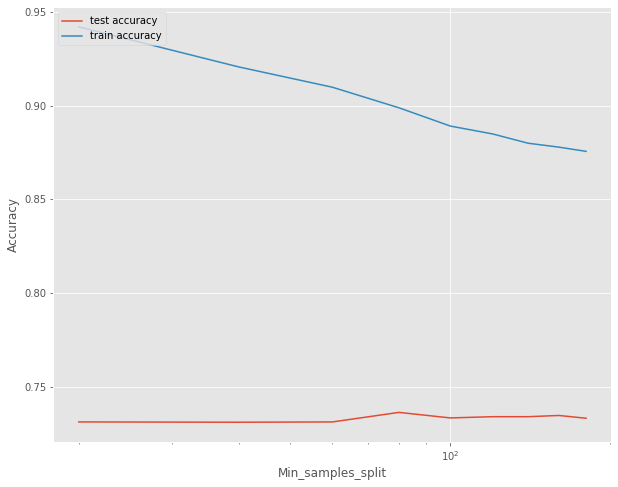

In [107]:
plt.figure(figsize=(10 , 8))
plt.plot(cv_results_ms['param_min_samples_split'] , cv_results_ms['mean_test_score'])
plt.plot(cv_results_ms['param_min_samples_split'] , cv_results_ms['mean_train_score'])
plt.xlabel('Min_samples_split')
plt.ylabel('Accuracy')
plt.legend(['test accuracy', 'train accuracy'], loc='upper left')
plt.xscale('log')

In [108]:
n_folds = 5
parameters = {'min_samples_leaf': range (1 , 20)}

dtree = DecisionTreeClassifier()

tree_ml = GridSearchCV(dtree , parameters , cv=n_folds , n_jobs = -1 , return_train_score = True)
tree_ml.fit(X_train, y_train)


cv_results_ml = pd.DataFrame(tree_ml.cv_results_)
cv_results_ml

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,1.948387,0.134038,0.001996,1.784161e-07,1,{'min_samples_leaf': 1},0.720263,0.735849,0.722496,0.732128,...,0.727586,0.005808,2,0.990967,0.991993,0.989532,0.990560,0.989945,0.990599,0.000854
1,1.529705,0.067874,0.001996,6.289914e-07,2,{'min_samples_leaf': 2},0.712059,0.729286,0.728243,0.711586,...,0.720197,0.007589,6,0.906385,0.899199,0.905172,0.902935,0.900267,0.902792,0.002752
2,1.314963,0.053385,0.001796,3.991847e-04,3,{'min_samples_leaf': 3},0.723544,0.727646,0.725780,0.724733,...,0.723317,0.004430,3,0.865120,0.859988,0.866379,0.861892,0.862918,0.863259,0.002275
3,1.133659,0.063114,0.002195,3.987077e-04,4,{'min_samples_leaf': 4},0.723544,0.718622,0.724959,0.733772,...,0.721346,0.009165,4,0.834941,0.832067,0.835386,0.831315,0.827211,0.832184,0.002945
4,0.976384,0.044183,0.001796,3.991615e-04,5,{'min_samples_leaf': 5},0.727646,0.730107,0.733990,0.739523,...,0.728736,0.009092,1,0.818723,0.815233,0.817734,0.814693,0.810384,0.815353,0.002904
5,0.875456,0.031930,0.001596,4.890452e-04,6,{'min_samples_leaf': 6},0.713700,0.734208,0.718391,0.732128,...,0.721182,0.010402,5,0.800452,0.802094,0.808292,0.802175,0.799302,0.802463,0.003106
6,0.805242,0.029881,0.002195,7.462510e-04,7,{'min_samples_leaf': 7},0.718622,0.727646,0.715928,0.716516,...,0.716913,0.006957,10,0.791829,0.793677,0.798235,0.785553,0.788016,0.791462,0.004421
7,0.738220,0.035891,0.001397,4.891229e-04,8,{'min_samples_leaf': 8},0.734208,0.739130,0.713465,0.711586,...,0.719212,0.015357,7,0.786697,0.780333,0.792898,0.781244,0.777345,0.783703,0.005502
8,0.679379,0.033051,0.001597,4.888119e-04,9,{'min_samples_leaf': 9},0.740771,0.717801,0.709360,0.707477,...,0.715107,0.014023,12,0.780538,0.770889,0.787767,0.773651,0.769752,0.776519,0.006758
9,0.642081,0.025375,0.002196,9.755506e-04,10,{'min_samples_leaf': 10},0.727646,0.725185,0.712644,0.714051,...,0.718391,0.006626,9,0.777458,0.766167,0.783456,0.768931,0.764621,0.772127,0.007195


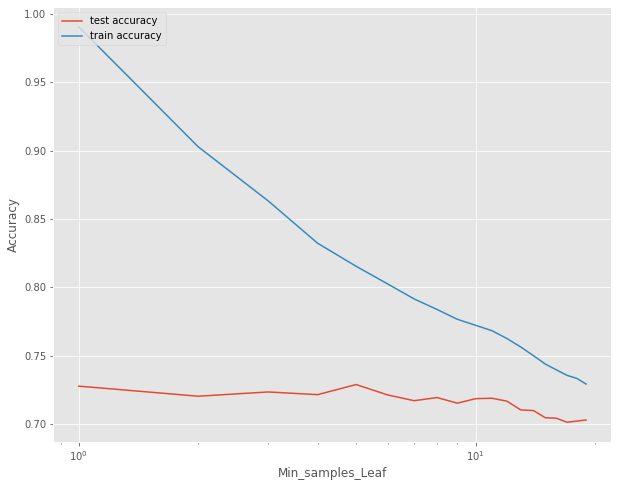

In [109]:
plt.figure(figsize=(10 , 8))
plt.plot(cv_results_ml['param_min_samples_leaf'] , cv_results_ml['mean_test_score'])
plt.plot(cv_results_ml['param_min_samples_leaf'] , cv_results_ml['mean_train_score'])
plt.xlabel('Min_samples_Leaf')
plt.ylabel('Accuracy')
plt.legend(['test accuracy', 'train accuracy'], loc='upper left')
plt.xscale('log')

In [110]:
n_folds = 5
parameters = {'max_depth':range (1,20)}

dtree = DecisionTreeClassifier()

tree_d = GridSearchCV(dtree , parameters , cv=n_folds , n_jobs = -1 , return_train_score = True)
tree_d.fit(X_train, y_train)


cv_results_d = pd.DataFrame(tree_d.cv_results_)
cv_results_d

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.135636,0.004039,0.000998,5.519789e-07,1,{'max_depth': 1},0.614438,0.565217,0.598522,0.594906,...,0.591626,0.016250,19,0.599056,0.565387,0.603038,0.603940,0.606403,0.595565,0.015273
1,0.144410,0.012020,0.001397,4.883445e-04,2,{'max_depth': 2},0.630025,0.625103,0.607553,0.605588,...,0.615271,0.010197,18,0.617943,0.608499,0.623974,0.612559,0.625077,0.617610,0.006401
2,0.149995,0.009497,0.002196,1.466447e-03,3,{'max_depth': 3},0.643970,0.640689,0.616585,0.608874,...,0.626601,0.013631,17,0.634983,0.625949,0.635263,0.621178,0.642110,0.631896,0.007422
3,0.169545,0.014033,0.000999,6.975526e-07,4,{'max_depth': 4},0.642330,0.648893,0.636289,0.622843,...,0.635796,0.009318,16,0.637651,0.637857,0.650452,0.634106,0.654217,0.642857,0.007942
4,0.184704,0.011483,0.001400,4.854415e-04,5,{'max_depth': 5},0.643150,0.654635,0.637931,0.635168,...,0.639737,0.008955,15,0.651817,0.651612,0.652915,0.644777,0.659758,0.652176,0.004759
5,0.195675,0.015156,0.001398,4.887140e-04,6,{'max_depth': 6},0.652174,0.660377,0.646141,0.645850,...,0.646470,0.010732,14,0.662492,0.664545,0.667488,0.656269,0.662015,0.662562,0.003690
6,0.209037,0.011400,0.000998,9.368364e-07,7,{'max_depth': 7},0.648072,0.661198,0.641215,0.654889,...,0.651067,0.006702,13,0.667009,0.669062,0.672003,0.671045,0.678022,0.671428,0.003717
7,0.215421,0.005534,0.001199,3.989938e-04,8,{'max_depth': 8},0.643970,0.665299,0.647783,0.669680,...,0.654680,0.010622,12,0.675221,0.681995,0.685755,0.685409,0.689103,0.683497,0.004710
8,0.234567,0.006719,0.001399,4.881320e-04,9,{'max_depth': 9},0.646432,0.662838,0.651067,0.666393,...,0.656814,0.007338,11,0.682611,0.693903,0.693966,0.699364,0.702032,0.694375,0.006668
9,0.251925,0.007868,0.001398,4.885204e-04,10,{'max_depth': 10},0.648893,0.666940,0.651067,0.662284,...,0.657635,0.006778,10,0.691234,0.702936,0.703407,0.710651,0.712087,0.704063,0.007404


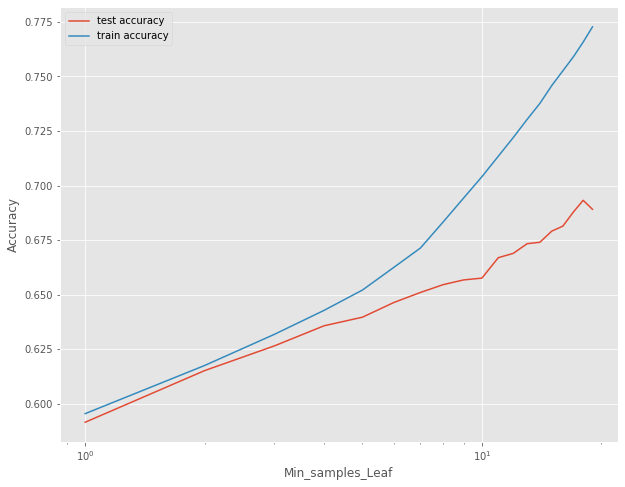

In [111]:
plt.figure(figsize=(10 , 8))
plt.plot(cv_results_d['param_max_depth'] , cv_results_d['mean_test_score'])
plt.plot(cv_results_d['param_max_depth'] , cv_results_d['mean_train_score'])
plt.xlabel('Min_samples_Leaf')
plt.ylabel('Accuracy')
plt.legend(['test accuracy', 'train accuracy'], loc='upper left')
plt.xscale('log')

In [112]:
print(tree_split.best_params_)
print(tree_ml.best_params_)
print(tree_d.best_params_)

{'min_samples_split': 80}
{'min_samples_leaf': 5}
{'max_depth': 18}


In [113]:
dt = DecisionTreeClassifier(max_depth = 20 , min_samples_leaf = 10 , min_samples_split = 80)
dt.fit(X_train , y_train)


y_pred_dt = dt.predict(X_test)

ac = accuracy_score(y_test , y_pred_dt)
print(ac*100)

71.43795141168746


***Test Data Report***
Best max_depth =  20
Best min_samples_split =  80
AUC =  74.6127285302758


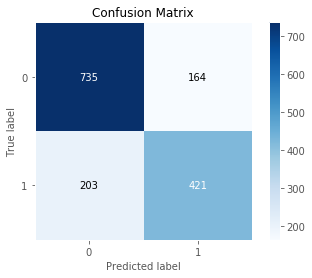

In [114]:
optimal_depth = 20
optimal_split = 80

print("***Test Data Report***")
print("Best max_depth = ",optimal_depth)
print("Best min_samples_split = ",optimal_split)
fpr, tpr, threshold = metrics.roc_curve(y_test, lr.predict(X_test))
auc = metrics.auc(fpr, tpr)
print("AUC = ",auc*100)
skplt.metrics.plot_confusion_matrix(y_test, pred)
plt.show()

## Random Forest on BOW

In [115]:
max_depths = [2,4,6,9,11]
base_learners = [1, 5, 10, 50, 100]
param_grid = {'max_depth': max_depths,'n_estimators':base_learners}


model = GridSearchCV(RandomForestClassifier(class_weight='balanced'), param_grid, scoring = 'roc_auc', cv=3 , n_jobs = -1 , return_train_score = True)
model.fit(X_train, y_train)

print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(X_train, y_train))

Model with best parameters :
 RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=11, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)
Accuracy of the model :  0.8841418246380883


In [116]:
y_pred_rf = model.predict(X_test)
ac = accuracy_score(y_test , y_pred_rf)
ac

0.7912015758371634

In [117]:
print(classification_report(y_test , y_pred_rf))

              precision    recall  f1-score   support

           0       0.77      0.91      0.84       899
           1       0.83      0.62      0.71       624

    accuracy                           0.79      1523
   macro avg       0.80      0.76      0.77      1523
weighted avg       0.80      0.79      0.78      1523



In [118]:
dataframe = pd.DataFrame(model.cv_results_)
dataframe.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.010969,0.000003,0.004324,0.000470,2,1,"{'max_depth': 2, 'n_estimators': 1}",0.503862,0.503097,0.506895,0.504617,0.001640,25,0.506513,0.504598,0.508779,0.506630,0.001709
1,0.027924,0.002443,0.010972,0.004534,2,5,"{'max_depth': 2, 'n_estimators': 5}",0.545640,0.559567,0.519436,0.541552,0.016635,21,0.555029,0.566886,0.533374,0.551763,0.013875
2,0.044876,0.003552,0.007981,0.000812,2,10,"{'max_depth': 2, 'n_estimators': 10}",0.605739,0.576223,0.651022,0.610987,0.030758,18,0.631178,0.591474,0.666424,0.629692,0.030617
3,0.177857,0.006780,0.024600,0.000469,2,50,"{'max_depth': 2, 'n_estimators': 50}",0.754545,0.714886,0.732543,0.733995,0.016225,10,0.754310,0.746006,0.760822,0.753712,0.006063
4,0.355383,0.028955,0.045213,0.001244,2,100,"{'max_depth': 2, 'n_estimators': 100}",0.775994,0.767045,0.759492,0.767513,0.006745,9,0.802122,0.821549,0.804753,0.809475,0.008605


C:\Users\Mahmudur Limon\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



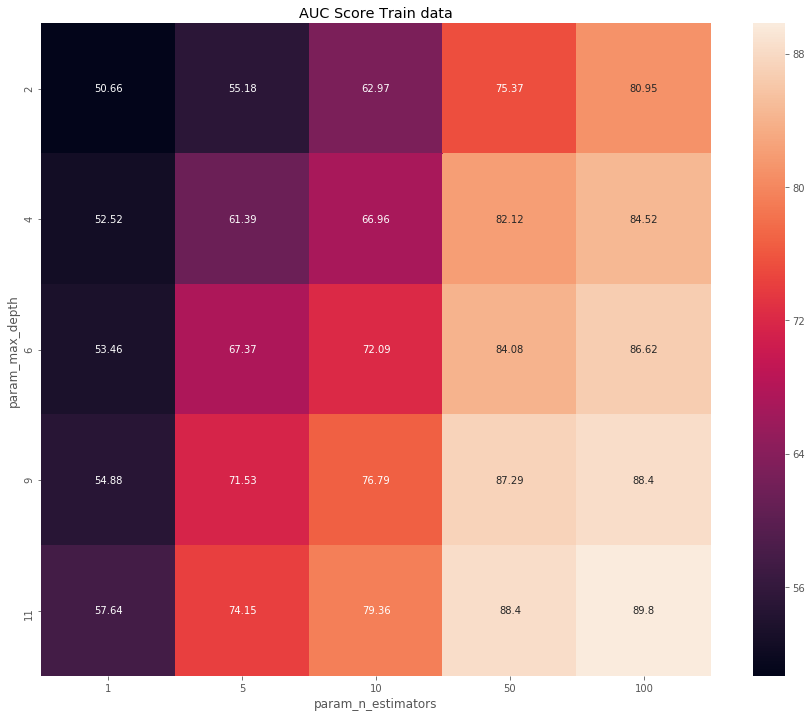

In [119]:
# Train Data Auc Score Vs hyperparameter Heatmap
max_scores = dataframe.groupby(['param_max_depth', 
                                    'param_n_estimators']).max()
max_scores = max_scores.unstack()[['mean_test_score', 'mean_train_score']]
plt.figure(figsize = (15 , 12))
sns.heatmap(max_scores.mean_train_score*100, annot=True, fmt='.4g');
ax = plt.axes()
ax.set_title('AUC Score Train data')
plt.show()

C:\Users\Mahmudur Limon\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



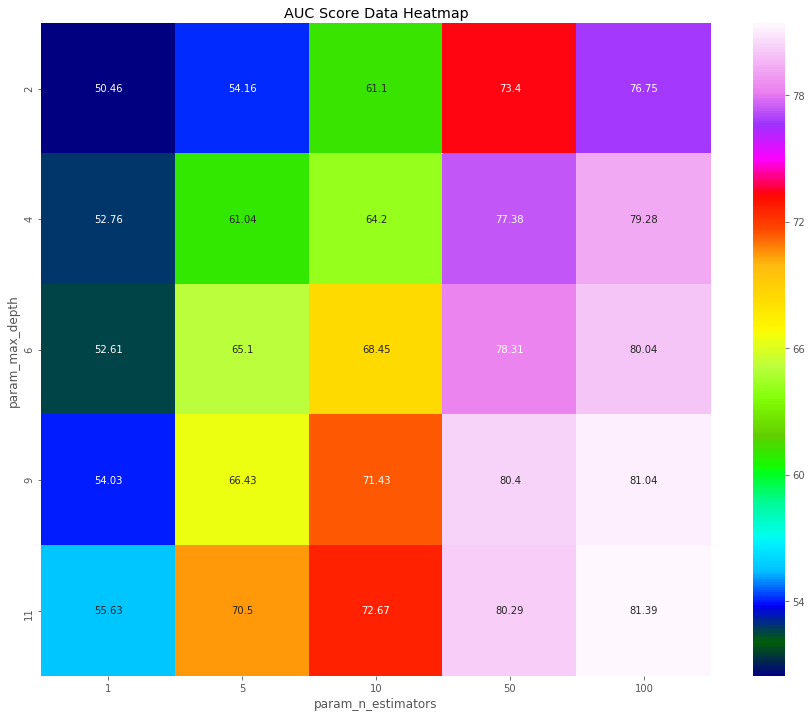

In [120]:
# CV Data Auc Score Vs hyperparameter Heatmap
max_scores = dataframe.groupby(['param_max_depth', 
                                    'param_n_estimators']).max()
max_scores = max_scores.unstack()[['mean_test_score', 'mean_train_score']]
plt.figure(figsize = (15 , 12))
sns.heatmap(max_scores.mean_test_score*100, annot=True, fmt='.4g' , cmap = 'gist_ncar')
ax = plt.axes()
ax.set_title('AUC Score Data Heatmap')
plt.show()

***Test Data Report***
Best max_depth =  11
Best Base Learners =  100
AUC =  73.7180378483215


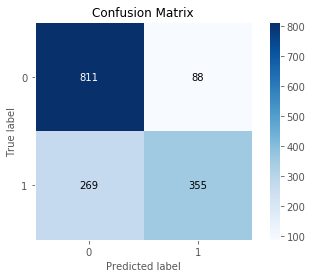

In [121]:
optimal_depth = 11
optimal_estimators = 100

lr = RandomForestClassifier(n_estimators=optimal_estimators, max_depth=optimal_depth, class_weight='balanced')
lr.fit(X_train_BOW,y_train)
pred = lr.predict(X_test_BOW)

print("***Test Data Report***")
print("Best max_depth = ",optimal_depth)
print("Best Base Learners = ",optimal_estimators)
fpr, tpr, threshold = metrics.roc_curve(y_test, lr.predict(X_test))
auc = metrics.auc(fpr, tpr)
print("AUC = ",auc*100)
skplt.metrics.plot_confusion_matrix(y_test, pred)
plt.show()

In [122]:
rf = RandomForestClassifier()
rf.fit(X_train , y_train)

y_pred_rf = rf.predict(X_test)

ac_rf = accuracy_score(y_test , y_pred_rf)
print(ac_rf*100)

C:\Users\Mahmudur Limon\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.



78.13525935653315


In [123]:
test_pred = rf.predict(test_BOW)

In [124]:
# test_pred = rf.predict(test_BOW)
# submission['target'] = test_pred.astype(int)
# submission.to_csv('submission02.csv', index=False)

In [125]:
n_folds = 10
parameters = {'max_depth': range(2, 30, 2)}

rf = RandomForestClassifier(random_state = 100)
grd_search_max = GridSearchCV(rf , parameters , cv = n_folds , n_jobs = -1 , return_train_score = True)

grd_search_max.fit(X_train , y_train)
print('Best parameter for max_depth: ',grd_search_max.best_params_)

scores = grd_search_max.cv_results_
pd.DataFrame(scores).head()

C:\Users\Mahmudur Limon\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.



Best parameter for max_depth:  {'max_depth': 28}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.053853,0.007762,0.003690,0.000638,2,{'max_depth': 2},0.570492,0.580328,0.581967,0.577997,...,0.583029,0.579091,0.577267,0.577814,0.567050,0.579168,0.590660,0.572601,0.577340,0.006466
1,0.070212,0.005716,0.003691,0.000639,4,{'max_depth': 4},0.573770,0.604918,0.611475,0.599343,...,0.609489,0.597336,0.602262,0.604452,0.585660,0.601240,0.606895,0.602882,0.600036,0.006944
2,0.100331,0.005715,0.003592,0.000914,6,{'max_depth': 6},0.604918,0.626230,0.622951,0.627258,...,0.633942,0.631819,0.616858,0.618318,0.606276,0.619847,0.622583,0.631886,0.621803,0.008236
3,0.135936,0.015145,0.003591,0.000489,8,{'max_depth': 8},0.626230,0.642623,0.637705,0.632184,...,0.647993,0.644226,0.636380,0.636015,0.622149,0.647209,0.641554,0.648121,0.640284,0.007511
4,0.159673,0.010311,0.003490,0.000668,10,{'max_depth': 10},0.626230,0.665574,0.644262,0.660099,...,0.670985,0.665754,0.660281,0.667396,0.640029,0.661620,0.650675,0.660161,0.660008,0.008978


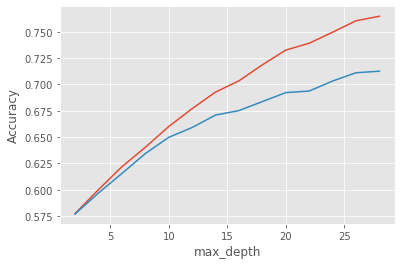

In [126]:
plt.figure()
plt.plot(scores["param_max_depth"],scores["mean_train_score"],label="Training accuracy")
plt.plot(scores["param_max_depth"],scores["mean_test_score"],label="Test accuracy")
plt.xlabel('max_depth')
plt.ylabel('Accuracy')
plt.show()


In [127]:
n_folds = 5
parameters = {'n_estimators': range(50, 500, 50)}

rf = RandomForestClassifier(random_state = 100)
grd_search_est = GridSearchCV(rf , parameters , cv = n_folds , n_jobs = -1 , return_train_score = True)

grd_search_est.fit(X_train, y_train)
print('Best parameter for n_estimators: ',grd_search_est.best_params_)

scores_1 = grd_search_est.cv_results_
pd.DataFrame(scores_1).head()

Best parameter for n_estimators:  {'n_estimators': 450}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,11.363212,0.183034,0.066424,0.002326,50,{'n_estimators': 50},0.780148,0.787531,0.778325,0.771569,...,0.778818,0.005213,9,0.989530,0.990762,0.988916,0.989945,0.989739,0.989778,0.000600
1,22.629489,0.418266,0.135637,0.003569,100,{'n_estimators': 100},0.785890,0.785070,0.780788,0.771569,...,0.780788,0.005086,8,0.990556,0.991993,0.989532,0.990355,0.989945,0.990476,0.000836
2,34.057131,0.644167,0.205052,0.014841,150,{'n_estimators': 150},0.785070,0.784249,0.785714,0.779786,...,0.783744,0.002077,5,0.990967,0.991993,0.989532,0.990560,0.989945,0.990599,0.000854
3,45.452464,0.698441,0.280052,0.025305,200,{'n_estimators': 200},0.785070,0.787531,0.787356,0.778965,...,0.784729,0.003101,3,0.990967,0.991993,0.989532,0.990560,0.989945,0.990599,0.000854
4,56.577120,0.990808,0.337498,0.009389,250,{'n_estimators': 250},0.788351,0.786710,0.786535,0.779786,...,0.785222,0.002950,2,0.990967,0.991993,0.989532,0.990560,0.989945,0.990599,0.000854


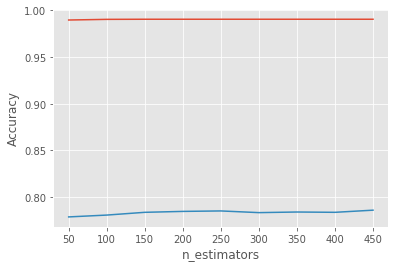

In [128]:
plt.figure()
plt.plot(scores_1["param_n_estimators"],scores_1["mean_train_score"],label="Training accuracy")
plt.plot(scores_1["param_n_estimators"],scores_1["mean_test_score"],label="Test accuracy")
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')
plt.show()

In [151]:
n_folds = 5
parameters = {'min_samples_leaf': range(30, 400, 30)}

rf = RandomForestClassifier(random_state = 100)
grd_search_lf = GridSearchCV(rf , parameters , cv = n_folds , return_train_score = True)

grd_search_lf.fit(X_train, y_train)
print('Best parameter for min_samples_leaf: ',grd_search_lf.best_params_)

scores_2 = grd_search_lf.cv_results_
pd.DataFrame(scores_2).head()

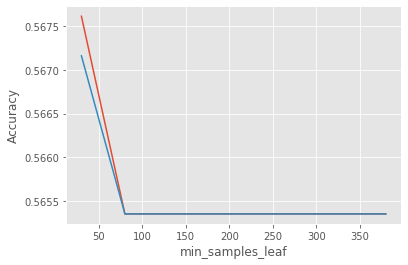

In [130]:
plt.figure()
plt.plot(scores_2["param_min_samples_leaf"],scores_2["mean_train_score"],label="Training accuracy")
plt.plot(scores_2["param_min_samples_leaf"],scores_2["mean_test_score"],label="Test accuracy")
plt.xlabel('min_samples_leaf')
plt.ylabel('Accuracy')
plt.show()

In [131]:
n_folds = 5
parameters = {'min_samples_split': range(10, 400, 50)}

rf = RandomForestClassifier()
grd_search_sp = GridSearchCV(rf , parameters , cv = n_folds , n_jobs = -1, return_train_score = True)

grd_search_sp.fit(X_train, y_train)
print('Best parameter for min_samples_split: ',grd_search_sp.best_params_)

score_3 = grd_search_sp.cv_results_
pd.DataFrame(score_3).head()

C:\Users\Mahmudur Limon\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.



Best parameter for min_samples_split:  {'min_samples_split': 210}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,2.887842,0.181887,0.029783,0.010042,10,{'min_samples_split': 10},0.776866,0.769483,0.772578,0.770748,...,0.770443,0.004678,8,0.957093,0.953808,0.955460,0.953417,0.952186,0.954393,0.001709
1,2.781269,0.112865,0.032731,0.020011,60,{'min_samples_split': 60},0.782609,0.772765,0.770936,0.773213,...,0.774713,0.004078,6,0.923630,0.930404,0.924056,0.923456,0.927150,0.925739,0.002693
2,2.307006,0.248821,0.021604,0.005970,110,{'min_samples_split': 110},0.787531,0.787531,0.769294,0.768283,...,0.777668,0.008448,2,0.921577,0.914391,0.917488,0.915247,0.913400,0.916421,0.002910
3,1.785395,0.094393,0.018012,0.001086,160,{'min_samples_split': 160},0.770304,0.771944,0.756979,0.768283,...,0.770936,0.009664,7,0.893451,0.913570,0.907430,0.905192,0.901293,0.904187,0.006681
4,1.551075,0.278017,0.019642,0.008218,210,{'min_samples_split': 210},0.788351,0.777687,0.773399,0.770748,...,0.777997,0.006070,1,0.893656,0.900226,0.892652,0.890417,0.888775,0.893145,0.003929


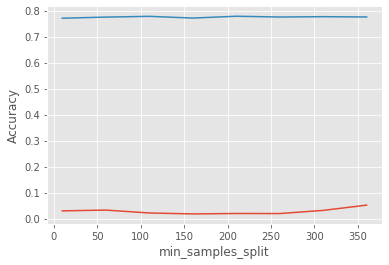

In [132]:
plt.figure()
plt.plot(score_3["param_min_samples_split"],score_3["mean_score_time"],label="Training accuracy")
plt.plot(score_3["param_min_samples_split"],score_3["mean_test_score"],label="Test accuracy")
plt.xlabel('min_samples_split')
plt.ylabel('Accuracy')
plt.show()

In [133]:
print('Best parameter for max_depth: ',grd_search_max.best_params_)
print('Best parameter for min_samples_leaf: ',grd_search_lf.best_params_)
print('Best parameter for min_samples_split: ',grd_search_sp.best_params_)
print('Best parameter for n_estimators: ',grd_search_est.best_params_)

Best parameter for max_depth:  {'max_depth': 28}
Best parameter for min_samples_leaf:  {'min_samples_leaf': 30}
Best parameter for min_samples_split:  {'min_samples_split': 210}
Best parameter for n_estimators:  {'n_estimators': 450}


In [147]:
new_rf = RandomForestClassifier(n_estimators = 450 , max_depth = 28 , min_samples_leaf = 30 , min_samples_split = 210)
new_rf.fit(X_train , y_train)

y_pred_rf = new_rf.predict(X_test)

ac_rf = accuracy_score(y_test , y_pred_rf)
print(ac_rf*100)

59.22521339461589


## GBDT on BOW

In [135]:
learn_rate = {'learning_rate': [0.001 , 0.01 , 0.1 , 1.0 , 1.3]}
folds = 5

In [136]:
GBC = GradientBoostingClassifier()

grd_search_lr = GridSearchCV(GBC , cv = folds , param_grid = learn_rate , n_jobs = -1)
grd_search_lr.fit(X_train, y_train)
print('Best parameter for max_depth: ' , grd_search_lr.best_params_)

cv_results_gbdt = pd.DataFrame(grd_search_lr.cv_results_)
cv_results_gbdt.head()

Best parameter for max_depth:  {'learning_rate': 1.0}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,16.984334,0.897454,0.005984,0.003026,0.001,{'learning_rate': 0.001},0.565217,0.565217,0.565681,0.565325,0.565325,0.565353,0.000171,5
1,15.177017,0.114749,0.004986,0.000631,0.01,{'learning_rate': 0.01},0.675964,0.670221,0.640394,0.652424,0.635990,0.655008,0.015829,4
2,14.394312,0.656705,0.005184,0.000977,0.1,{'learning_rate': 0.1},0.741591,0.726825,0.734811,0.734593,0.744454,0.736453,0.006153,3
3,13.637532,0.086858,0.004786,0.000399,1,{'learning_rate': 1.0},0.770304,0.770304,0.760263,0.764996,0.780608,0.769294,0.006782,1
4,13.153236,1.128970,0.003988,0.000632,1.3,{'learning_rate': 1.3},0.756358,0.750615,0.751232,0.760066,0.768283,0.757307,0.006490,2


In [137]:
sub_sample = {"subsample": [0.3, 0.6, 0.9]}
folds = 5

In [138]:
GBC = GradientBoostingClassifier(max_depth=2, n_estimators=200)

grd_search_ss = GridSearchCV(GBC , cv = folds , param_grid = sub_sample)
grd_search_ss.fit(X_train, y_train)
print('Best parameter for max_depth: ',grd_search_ss.best_params_)

cv_results_sub = pd.DataFrame(grd_search_lr.cv_results_)
cv_results_sub.head()

Best parameter for max_depth:  {'subsample': 0.6}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,16.984334,0.897454,0.005984,0.003026,0.001,{'learning_rate': 0.001},0.565217,0.565217,0.565681,0.565325,0.565325,0.565353,0.000171,5
1,15.177017,0.114749,0.004986,0.000631,0.01,{'learning_rate': 0.01},0.675964,0.670221,0.640394,0.652424,0.635990,0.655008,0.015829,4
2,14.394312,0.656705,0.005184,0.000977,0.1,{'learning_rate': 0.1},0.741591,0.726825,0.734811,0.734593,0.744454,0.736453,0.006153,3
3,13.637532,0.086858,0.004786,0.000399,1,{'learning_rate': 1.0},0.770304,0.770304,0.760263,0.764996,0.780608,0.769294,0.006782,1
4,13.153236,1.128970,0.003988,0.000632,1.3,{'learning_rate': 1.3},0.756358,0.750615,0.751232,0.760066,0.768283,0.757307,0.006490,2


In [139]:
#GBC = GradientBoostingClassifier(subsample = 0.6 , learning_rate = 0.1 , n_estimators=50 , max_features = 8 , min_samples_leaf = 30 , min_samples_split = 10)

GBC = GradientBoostingClassifier(subsample = 0.6 , learning_rate = 0.9)
GBC.fit(X_train , y_train)

y_gbr = GBC.predict(X_test)

ac_gbr = accuracy_score(y_test , y_gbr)
print(ac_gbr*100)

76.88772160210111


## XGB on BOW

In [140]:
classifier = XGBClassifier()
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

ac_xg = accuracy_score(y_test , y_pred)
print(ac_xg*100)

78.8575180564675


In [141]:
print(classification_report(y_test , y_pred))

              precision    recall  f1-score   support

           0       0.77      0.91      0.84       899
           1       0.82      0.62      0.71       624

    accuracy                           0.79      1523
   macro avg       0.80      0.76      0.77      1523
weighted avg       0.79      0.79      0.78      1523



In [142]:
max_depths = [2,4,6,9,11]
base_learners = [1, 5, 10, 50, 100]
param_grid = {'max_depth': max_depths,'n_estimators':base_learners}

model = GridSearchCV(xgb.XGBClassifier(scale_pos_weight=1), param_grid, scoring = 'roc_auc', cv=3 , n_jobs = -1 , return_train_score = True) 
model.fit(X_train, y_train)
print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(X_train, y_train))

Model with best parameters :
 XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)
Accuracy of the model :  0.9246830101888152


***Test Data Report***
Best max_depth =  11
Best Base Learners =  100
AUC =  73.7180378483215


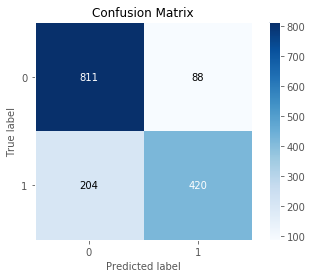

In [143]:
optimal_depth = 11
optimal_estimators = 150

xg_model = xgb.XGBClassifier(max_depth=optimal_depth, n_estimators=optimal_estimators, scale_pos_weight=1)
xg_model.fit(X_train,y_train)

pred = xg_model.predict(X_test)

print("***Test Data Report***")
print("Best max_depth = ",optimal_depth)
print("Best Base Learners = ",optimal_estimators)
fpr, tpr, threshold = metrics.roc_curve(y_test, lr.predict(X_test))
auc = metrics.auc(fpr, tpr)
print("AUC = ",auc*100)
skplt.metrics.plot_confusion_matrix(y_test, pred)
plt.show()

In [144]:
# test_pred = xg_model.predict(Test)

# submission['target'] = test_pred.astype(int)
# submission.to_csv('submission05xgb.csv', index=False)